In [35]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.svm import LinearSVC, SVC
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from time import time
import numpy as np

In [36]:
# get features and labels
data = pd.read_pickle('pifsc_embeddings2.pickle')
features = dict(data)
data = pd.read_pickle('pifsc_embeddings.pkl')
features.update(data)

cols = ["species","image","distinctiveness","quality"]
labels1 = pd.read_csv('pifsc_labels_detail.csv')[cols]

cols = ["species","filename","distinctiveness","quality"]
labels2 = pd.read_csv('pifsc_labels2.csv')[cols]
labels2.columns = ["species","image","distinctiveness","quality"]

labels = pd.concat([labels1, labels2]).reset_index(drop=True)

In [37]:
# clean labels
is_na = labels.distinctiveness.isna()
labels = labels.loc[~is_na]
labels = labels.drop_duplicates(subset='image', keep='first')
# labels.reset_index(drop=False, inplace=True)

# clean features
imgs = labels.image.tolist()
features = {k: v for k, v in features.items() if k in imgs}
assert len(features) == len(labels)

In [38]:
# combine 3s & 4s
print(labels.distinctiveness.value_counts())
for index, row in labels.iterrows():
    if row.distinctiveness == 4:
        labels.at[index, 'distinctiveness'] = 3
print(labels.distinctiveness.value_counts())


distinctiveness
2.0    2343
1.0    1152
3.0      44
4.0      37
Name: count, dtype: int64
distinctiveness
2.0    2343
1.0    1152
3.0      81
Name: count, dtype: int64


In [39]:
# get data, split
Y = labels.distinctiveness
X = np.array([features[i] for i in labels.image])
# species = labels.species.astype('category').cat.codes
# X = np.insert(X, 0, species, axis=1)
# sc = StandardScaler()
# X = sc.fit_transform(X)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=42, stratify=Y)

In [40]:
# train Logistic regression
classifiers = [LogisticRegressionCV(cv=10, max_iter=5000, class_weight='balanced', multi_class='multinomial', n_jobs=-1),
               LinearSVC(class_weight='balanced', random_state=42, max_iter=10000),
               SVC(class_weight='balanced', random_state=42),
               SVC(class_weight='balanced', random_state=42, kernel='poly', degree=2),
               SVC(class_weight='balanced', random_state=42, kernel='poly')]
for cls in classifiers:
    cls.fit(X_train, Y_train)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


In [41]:
# # predict
# print("Predicting distinctiveness with logistic regression")
# t0 = time()
# preds1 = lrcv.predict(X_test)
# print("Done in %0.3fs" % (time() - t0))
# print("Predicting distinctiveness with SVM")
# t0 = time()
# preds2 = lsvc.predict(X_test)
# print("Done in %0.3fs" % (time() - t0))

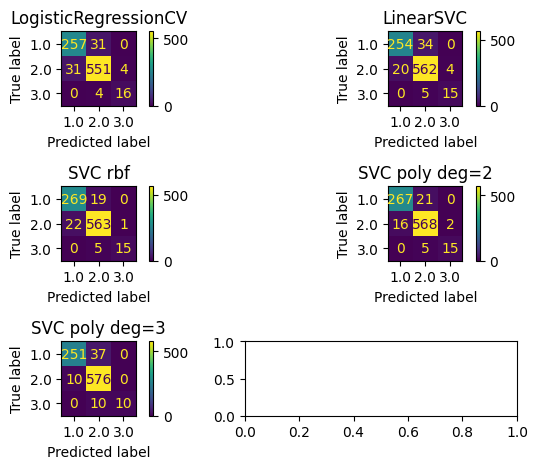

In [42]:
# results
fig, axes = plt.subplots(3, 2)
for cls, ax in zip(classifiers, axes.flatten()):
# print(classification_report(Y_test, preds1))
    ConfusionMatrixDisplay.from_estimator(cls, X_test, Y_test, ax=ax)
    if type(cls).__name__ == "SVC":
        string = f"SVC {cls.kernel}"
        if cls.kernel == 'poly':
            string += f" deg={cls.degree}"
        ax.title.set_text(string)
    else:
        ax.title.set_text(type(cls).__name__)
plt.tight_layout()

In [43]:
for cls in classifiers:
    pred = cls.predict(X_test)
    if type(cls).__name__ == "SVC":
        string = f"SVC {cls.kernel}"
        if cls.kernel == 'poly':
            string +=  f" deg={cls.degree}"
        print(string.center(53,'-'))
    else:
        print(type(cls).__name__.center(53, '-'))
    print(classification_report(Y_test, pred))

-----------------LogisticRegressionCV----------------
              precision    recall  f1-score   support

         1.0       0.89      0.89      0.89       288
         2.0       0.94      0.94      0.94       586
         3.0       0.80      0.80      0.80        20

    accuracy                           0.92       894
   macro avg       0.88      0.88      0.88       894
weighted avg       0.92      0.92      0.92       894

----------------------LinearSVC----------------------
              precision    recall  f1-score   support

         1.0       0.93      0.88      0.90       288
         2.0       0.94      0.96      0.95       586
         3.0       0.79      0.75      0.77        20

    accuracy                           0.93       894
   macro avg       0.88      0.86      0.87       894
weighted avg       0.93      0.93      0.93       894

-----------------------SVC rbf-----------------------
              precision    recall  f1-score   support

         1.0       0.